# K-Means Clustering

In [569]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [570]:
# Suppress memory leak warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

In [571]:
# Define possible dataset paths.
paths = [
    '../datasets/_integrated_data/dropped-column-if-missing-value/data.csv',                    # 0
    '../datasets/_integrated_data/dropped-column-if-missing-value/data-gendered.csv',           # 1
    '../datasets/_integrated_data/dropped-row-if-missing-value/data.csv',                       # 2
    '../datasets/_integrated_data/dropped-row-if-missing-value/data-gendered.csv',              # 3
    '../datasets/_integrated_data/missing-pollutant-values-as-NA/data.csv',                     # 4
    '../datasets/_integrated_data/missing-pollutant-values-as-NA/data-gendered.csv',            # 5
    '../datasets/_integrated_data/missing-pollutant-values-as-NaN/data.csv',                    # 6
    '../datasets/_integrated_data/missing-pollutant-values-as-NaN/data-gendered.csv',           # 7
    '../datasets/_integrated_data/missing-pollutant-values-filled-somehow/data.csv',            # 8
    '../datasets/_integrated_data/missing-pollutant-values-filled-somehow/data-gendered.csv'    # 9
]

# Choose a dataset.
chosen_dataset = 1

# Load the data
df = pd.read_csv(paths[chosen_dataset])

# Count of number of pollutant features in the dataset
column_list = ['CO ppm', 'NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']
n_pollutants = sum([1 for col in df.columns if col in column_list])

# Show the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of pollutant features: {n_pollutants}")
df.describe()

Dataset shape: (130, 17)
Number of pollutant features: 3


,NO pphm,NO2 pphm,OZONE pphm,asthma edp [f],asthma edp [m],asthma hospitalisations [f],asthma hospitalisations [m],copd deaths [f],copd deaths [m],copd hospitalisations [f],copd hospitalisations [m],iap deaths [f],iap deaths [m],iap hospitalisations [f],iap hospitalisations [m]
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.00000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,0.547513,0.585202,1.854216,376.920385,346.448846,128.024462,91.571808,21.920000,30.40500,209.263846,244.075385,7.806154,9.291923,293.408077,364.459615
std,0.671731,0.326022,0.249853,147.322172,121.227754,40.208431,26.676362,7.231492,9.04189,81.773675,86.668726,2.237805,2.616518,82.550957,87.753538
min,0.055302,0.173631,1.279167,119.700000,131.200000,59.725000,33.425000,7.900000,11.00000,56.100000,65.500000,3.900000,4.200000,135.000000,182.500000
25%,0.190634,0.327954,1.711455,253.850000,248.975000,101.352083,74.193750,15.575000,24.08750,146.816667,178.100000,6.312500,7.400000,239.987500,309.650000
50%,0.342790,0.506030,1.861842,378.625000,332.100000,121.325000,89.100000,23.512500,31.73750,215.400000,248.050000,7.762500,9.000000,296.800000,366.950000
75%,0.632921,0.767641,2.019923,464.900000,424.575000,149.337500,103.487500,27.050000,35.37500,261.075000,289.300000,8.900000,11.112500,342.000000,408.975000
max,3.079731,1.569617,2.411666,761.700000,729.600000,255.575000,183.250000,46.400000,57.40000,413.600000,482.233333,14.900000,16.700000,498.700000,599.500000


In [572]:
# Extract features and scale them
df = df.drop(columns=['financial year', 'lhd'])
features = df.iloc[:, :n_pollutants]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Optimal number of clusters: 2
Silhouette score: 0.6171786240835718


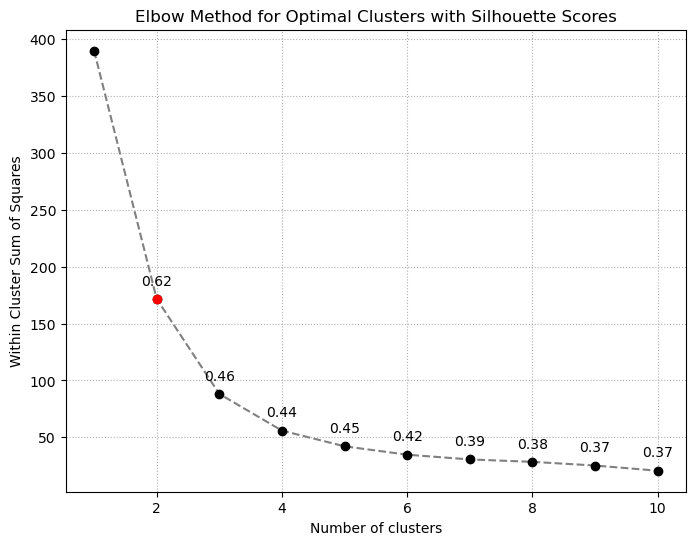

In [573]:
# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Calculate the silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, '--', color='grey')
plt.scatter(range(1, 11), wcss, color='black', zorder=5)
plt.title('Elbow Method for Optimal Clusters with Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.grid(True, linestyle=':')

# Annotate silhouette scores on the elbow method graph
for i, txt in enumerate(silhouette_scores, start=2):
    plt.annotate(f'{txt:.2f}', (i, wcss[i-1]), textcoords="offset points", xytext=(0,10), ha='center')

# Highlight the point with the highest silhouette score
max_silhouette_score = max(silhouette_scores)
max_silhouette_index = silhouette_scores.index(max_silhouette_score) + 2
plt.scatter(max_silhouette_index, wcss[max_silhouette_index - 1], color='red', zorder=5)

# Set optimal number of clusters based on the silhouette scores
optimal_clusters = max_silhouette_index

# Show the plot and initial results
print(f'Optimal number of clusters: {optimal_clusters}')
print(f'Silhouette score: {max_silhouette_score}')
plt.show()

In [574]:
# Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=808)
kmeans.fit(scaled_features)

# Add cluster labels to your original dataframe
df['Cluster'] = kmeans.labels_

# Print a count of rows in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

# Create a DataFrame for cluster counts
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ['Cluster', 'Count']

# Show the cluster counts
print(cluster_counts_df.to_string(index=False))

 Cluster  Count
       0     17
       1    113


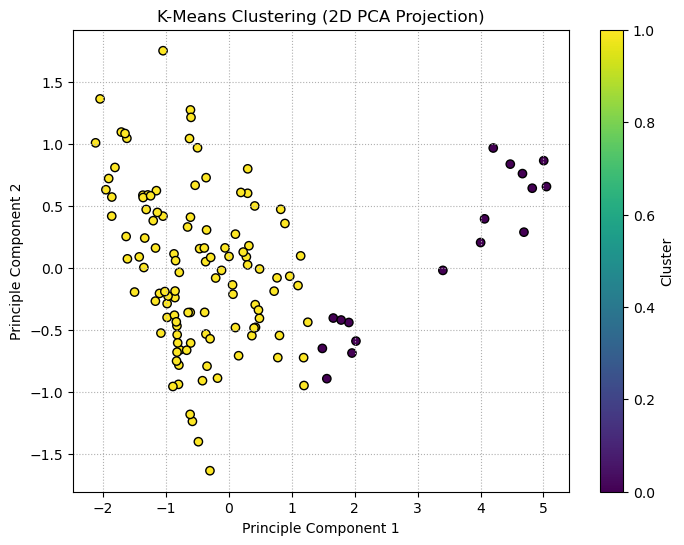

In [575]:
# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features)

# Plot the K-Means clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.title('K-Means Clustering (2D PCA Projection)')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.colorbar(label='Cluster')
plt.grid(True, linestyle=':')
plt.show()

In [576]:
# Put the principle components into a dataframe
principal_components_df = pd.DataFrame(pca.components_, columns=features.columns, index=['Principle Component 1', 'Principle Component 2'])

# Add cluster centers to the dataframe
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns, index=[f'Cluster {i} Centroid' for i in range(kmeans.n_clusters)])
principal_components_df = pd.concat([principal_components_df, cluster_centers], axis=0)

# Print the principal components
print("\nScaled Data:")
principal_components_df


Scaled Data:


,NO pphm,NO2 pphm,OZONE pphm
Principle Component 1,0.594244,0.599257,-0.536436
Principle Component 2,0.411682,0.346344,0.842950
Cluster 0 Centroid,2.085348,1.964390,-1.719158
Cluster 1 Centroid,-0.313725,-0.295528,0.258634


In [577]:
# Inverse transform the cluster centers to the original scale
cluster_centers_og_scale = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features.columns, index=[f'Cluster {i} Centroid' for i in range(kmeans.n_clusters)])
principal_components_df_og_scale = pd.concat([principal_components_df, cluster_centers_og_scale], axis=0)

# Print the principal components
print("Original Scale Data:")
principal_components_df_og_scale

Original Scale Data:


,NO pphm,NO2 pphm,OZONE pphm
Principle Component 1,0.594244,0.599257,-0.536436
Principle Component 2,0.411682,0.346344,0.842950
Cluster 0 Centroid,2.085348,1.964390,-1.719158
Cluster 1 Centroid,-0.313725,-0.295528,0.258634
Cluster 0 Centroid,1.942907,1.223168,1.426335
Cluster 1 Centroid,0.337587,0.489224,1.918587
